In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # image algebra 
import os # OS Paths
from statsmodels.stats.outliers_influence import variance_inflation_factor
import gc
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.model_selection import train_test_split
from statistics import mean
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#tqdm.pandas()
pd.options.display.max_rows = 999

In [2]:
train_metadata = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

In [3]:
train_metadata['age_bins'] = pd.qcut(train_metadata['age'], q=10)
age_bins = pd.qcut(train_metadata['age'], q=10).unique().categories
age_bin_map = {}
for index in range(len(age_bins)):
    bucket = age_bins[index]
    age_bin_map[bucket] = index

In [4]:
def apply_age_bins(x):
    for age_bin in age_bins:
        if x['age'] in age_bin:
            return age_bin_map[age_bin]

In [5]:
test_metadata = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")
test_metadata.head(5)

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [6]:
view_map = {'MLO':5,'CC':4,'AT':3,'LM':2,'ML':1,'LMO':0}

In [7]:
test_metadata['view'] = test_metadata['view'].apply(lambda x: view_map[x] if x in view_map.keys() else x)

In [8]:
test_metadata['age_bins'] = test_metadata.apply(lambda x: apply_age_bins(x),axis =1)

In [9]:
test_images_path = "/kaggle/input/bcd-test-npy/test/"
test_images = {}
for index in test_metadata.index:
    row = test_metadata.loc[index,:]
    folder = str(int(row['patient_id']))
    file = str(int(row['image_id']))
    if not folder in test_images.keys():
        test_images[folder] = {}
    test_images[folder][file] = test_images_path+'/'+file+'.npy'

In [10]:
class dataset:
    def __init__(self,data,target = None, dataset_type = 'train'):
        self.dataset_type = dataset_type
        self.images = data['image'].to_list()
        self.views = data['view'].to_list()
        self.age_bins = data['age_bins'].to_list()
        self.implants = data['implant'].to_list()
        if self.dataset_type == 'train':
            self.target = target.tolist()
            
    
    def randomize(self):
        p = np.random.permutation(len(self.images)).tolist()
        self.images = [self.images[i] for i in p]
        self.views = [self.views[i] for i in p]
        self.age_bins = [self.age_bins[i] for i in p]
        self.implants = [self.implants[i] for i in p]
        if self.dataset_type == 'train':
            self.target = [self.target[i] for i in p]
            
    def generate_batches(self, batch_size):
        #num_batches = len(self.images) // batch_size 
        for i in range(0,len(self.images),batch_size):
            if i < len(self.images) - 1:
                if i + batch_size < len(self.views) - 1:
                    views_batch = np.array(self.views[i:i+batch_size])
                    age_batch = np.array(self.age_bins[i:i+batch_size]).astype(float)
                    implants_batch = np.array(self.implants[i:i+batch_size]).astype(float)
                    if self.dataset_type == 'train':
                        target_batch = np.vstack([np.array(target) for target in self.target[i:i+batch_size]]).astype(float)
                    images_batch = []
                    for path in self.images[i:i+batch_size]:
                        img = np.load(path)
                        img = img/255
                        img = img.reshape(img.shape[0],img.shape[1],1)
                        images_batch.append(img)
                    images_batch = np.array(images_batch)
                else:
                    views_batch = np.array(self.views[i:])
                    age_batch = np.array(self.age_bins[i:]).astype(float)
                    implants_batch = np.array(self.implants[i:]).astype(float)
                    if self.dataset_type == 'train':
                        target_batch = np.vstack([np.array(target) for target in self.target[i:]]).astype(float)
                    images_batch = []
                    for path in self.images[i:]:
                        img = np.load(path)
                        img = img/255
                        img = img.reshape(img.shape[0],img.shape[1],1)
                        images_batch.append(img)
                    images_batch = np.array(images_batch)
                cat_batch = np.vstack([implants_batch,age_batch])
                cat_batch = cat_batch.transpose()
            if self.dataset_type == 'train':
                yield cat_batch, views_batch, images_batch, target_batch
            else:
                yield cat_batch, views_batch, images_batch, 0
    
    def size(self):
        return len(self.images)
    
    def num_batches(self,batch_size):
        if len(self.images) % batch_size == 0:
            num_batches = len(self.images) // batch_size
        else:
            num_batches = len(self.images) // batch_size
            num_batches += 1
        return num_batches

In [11]:
test_metadata['image'] = test_metadata.apply(lambda x: test_images[str(int(x['patient_id']))][str(int(x['image_id']))],axis = 1)
del(test_images)
gc.collect()

21

In [12]:
test_dataset = dataset(test_metadata,dataset_type = 'test')

(4, 1024, 1024, 1)


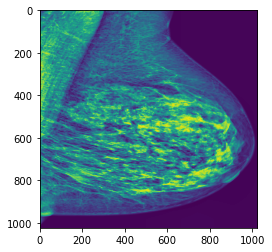

In [13]:
for cat_batch, views_batch, images_batch, target_batch in test_dataset.generate_batches(4):
    plt.imshow(images_batch[0])
    print(images_batch.shape)
    break

In [14]:
test_dataset = dataset(test_metadata,dataset_type = 'test')

In [15]:
class encoder(tf.keras.layers.Layer):
    def __init__(self,size:tuple):
        super(encoder, self).__init__()
        #encoder Module
        self.input_cnn = keras.layers.InputLayer(input_shape=(size[0],size[1],size[2]))
        # Ex0panding features for computation
        self.conv_1 = keras.layers.Conv2D(input_shape=(size[0],size[1],size[2]),filters=8,kernel_size=(3,3),padding='same',activation='relu')
        # 1/4 size reduction
        self.conv_2 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))
        self.conv_3 = keras.layers.Conv2D(filters = 16,kernel_size=(4,4),strides=(2,2),padding='same',activation='relu')
        self.conv_4 = keras.layers.Conv2D(filters = 32,kernel_size=(4,4),strides=(4,4),padding='same',activation='relu')
        self.conv_5 = keras.layers.BatchNormalization()
        # 1/2 size reduction
        self.conv_6 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))
        # 3x3 Filter third application
        self.conv_7 = keras.layers.Conv2D(filters = 64,kernel_size=(8,8),strides=(8,8),padding='same',activation='relu')
        # 1/4 size reduction
        self.conv_8 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))
        # 3x3 Filter third application
        self.conv_9 = keras.layers.BatchNormalization()
        self.conv_10 = keras.layers.Conv2D(filters = 1 ,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')
        #Flatten output
        self.flatten = keras.layers.Flatten()
        
    
    def call(self,inputs,training = True):
        x = self.input_cnn(inputs)
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        if training == True:
            x = self.conv_5(x,training = True)
        else:
            x = self.conv_5(x,training = False)
        x = self.conv_6(x)
        x = self.conv_7(x)
        x = self.conv_8(x)
        if training == True:
            x = self.conv_9(x,training = True)
        else:
            x = self.conv_9(x,training = False)
        x = self.conv_10(x)
        x = self.flatten(x)
        return x

In [16]:
en = encoder((1024,1024,1))
y = en(images_batch)

print("Weights: ", len(en.trainable_weights))

Weights:  14


In [17]:
class classifier(tf.keras.layers.Layer):
    def __init__(self,units):
        super(classifier, self).__init__()
        
        # Feature Reduction layer 1
        self.dense1 = keras.layers.Dense(units,activation = 'relu')
        
        # Dropout Layer
        #self.dropout = keras.layers.Dropout(0.1)
        
        # Feature Reduction Layer 2
        self.dense2 = keras.layers.Dense(int(units/8),activation = 'relu')
        
        # Classification Layer
        self.dense3 = keras.layers.Dense(1,activation = 'sigmoid')
    
    def call(self,inputs): 
        x = self.dense1(inputs)
        x = self.dense2(x)
        #x = self.dropout(x)
        x = self.dense3(x)
        return x

In [18]:
inputs = np.zeros((1049385,1))
cl = classifier(32)
y = cl(inputs)

print("Weights :", len(cl.trainable_weights))

Weights : 6


In [19]:
class BCDClassifier(tf.keras.Model):
    def __init__(self, size: tuple, optimizer = keras.optimizers.Adam(learning_rate=1e-3),loss_fn = keras.losses.BinaryCrossentropy(from_logits=False),metric = tf.keras.metrics.Accuracy()):
        super(BCDClassifier, self).__init__()
       
        #Input for catagorical data
        self.input_cat = keras.layers.InputLayer(input_shape = 2)
        
        #Encoder Layer for each view
        self.encode = encoder(size)
        
        #Concatenate Layer
        self.concat = keras.layers.Concatenate(axis = 1)
        
        #Classifier layer
        self.classify = classifier(32)
        
        #deffine model parameters
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = metric
        self.f1_tracker = tfa.metrics.F1Score(num_classes=2, threshold=0.5, average = 'micro')
        self.sk_metric_acc = accuracy_score
        self.sk_metric_f1 = f1_score
        self.acc_history = []
        self.loss_history = []
        self.f1_history = []

        
    # Forward pass of model - order does matter.
    def call(self, cat_batch, view_batch, images_batch, training = True):
        x1 = self.encode(images_batch,training)
                
        #calling Categorical processor
        x2 = self.input_cat(cat_batch)
            
        #calling 
        x12 = self.concat([x1,x2])
        x12 = self.classify(x12)          
        return x12
    
    def train_step(self,cat_batch, views_batch, images_batch, target_batch, training = True):
        
        with tf.GradientTape() as tape:
            logits = self(cat_batch, views_batch, images_batch,training)
            loss_value = self.loss_fn(target_batch, logits)

        grads = tape.gradient(loss_value, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.loss_tracker.update_state(loss_value)
        
        pred = []
        target = []
        threshold = 0.5
        for val in logits.numpy():
                if isinstance(val,np.ndarray):
                    for v_1 in val:
                        if isinstance(v_1,np.ndarray):
                            for v_2 in v_1:
                                if v_2 > threshold:
                                    pred.append(1.0)
                                else:
                                    pred.append(0.0)
                        else:
                            if v_1 > threshold:
                                    pred.append(1.0)
                            else:
                                pred.append(0.0)
                else:
                    if val > threshold:
                        pred.append(1.0)
                    else:
                        pred.append(0.0)
        for val in target_batch:
            if isinstance(val,np.ndarray):
                for v_1 in val:
                    if isinstance(v_1,np.ndarray):
                        for v_2 in v_1:
                            target.append(v_2)
                    else:
                        target.append(v_1)
            else:
                target.append(val)
        
        acc = self.sk_metric_acc(target,pred)
        f1 = self.sk_metric_f1(target,pred)
        self.f1_tracker.update_state(target_batch,logits)
        return {"Loss": self.loss_tracker.result(), "Accuracy": acc, 'F1-score':f1}
    
    def fit(self, train_dataset, test_dataset, epochs = 10, batch_size = 10, log_after_steps = 1000):
        train_dataset.randomize()
        for epoch in range(1,epochs+1):
            print("\nStart of epoch %d" % (epoch,))
            step = 0
            self.counter = 0
            for cat_batch, views_batch, images_batch, target_batch in train_dataset.generate_batches(batch_size):
                train_out = self.train_step(cat_batch, views_batch, images_batch, target_batch, training = True)
                step += batch_size

                # Log every 200 steps.
                if step % log_after_steps == 0:
                    print("Training loss at step %d: %.4f"  % (step, train_out['Loss'].numpy()))
                    print("Training Accuracy at step %d: %.4f"  % (step, train_out['Accuracy']))
                    print("Training F1 at step %d: %.4f"  % (step, train_out['F1-score']),'\n')

            loss, acc, f1 = self.eval(test_dataset, batch_size)
            print("Eval Loss for epoch: ",loss.numpy())
            print("Eval Accuracy for epoch: ",acc)
            print("Eval F1 for epoch: ",f1)
            self.acc_history.append(acc)
            self.loss_history.append(loss.numpy())
            self.f1_history.append(f1)
            
    def eval(self, dataset, batch_size, threshold = 0.5):
        step = 0
        out = []
        target = []
        final_out = []
        final_target = []
        for cat_batch, views_batch, images_batch, target_batch in dataset.generate_batches(batch_size):
            logits = self(cat_batch, views_batch, images_batch, training=False)  
            # Compute the loss value for this minibatch.
            loss_value = self.loss_fn(target_batch, logits)
            self.loss_tracker.update_state(loss_value)
            self.acc_tracker.update_state(logits,target_batch)
            self.f1_tracker.update_state(target_batch,logits)
            out.append(logits.numpy())
            target.append(target_batch)
        for val in out:
            if isinstance(val,np.ndarray):
                for v_1 in val:
                    if isinstance(v_1,np.ndarray):
                        for v_2 in v_1:
                            if v_2 > threshold:
                                final_out.append(1.0)
                            else:
                                final_out.append(0.0)
                    else:
                        if v_1 > threshold:
                                final_out.append(1.0)
                        else:
                            final_out.append(0.0)
            else:
                if val > threshold:
                    final_out.append(1.0)
                else:
                    final_out.append(0.0)
        for val in target:
            if isinstance(val,np.ndarray):
                for v_1 in val:
                    if isinstance(v_1,np.ndarray):
                        for v_2 in v_1:
                            final_target.append(v_2)
                    else:
                        final_target.append(v_1)
            else:
                final_target.append(val)
        return self.loss_tracker.result(), self.sk_metric_acc(final_target,final_out), self.sk_metric_f1(final_target,final_out)
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.loss_tracker, self.acc_tracker, self.f1_tracker]
         
    def build_graph(self):
        #Build for all Views
        cat_batch = []
        view_batch = []
        images_batch = []
        cat_batch.append(np.zeros(2))
        view_batch.append(np.array(1))
        images_batch.append(np.zeros((1024,1024,1))) 
        cat_batch = np.asarray(cat_batch)
        view_batch = np.asarray(view_batch)
        images_batch = np.asarray(images_batch)
        output = self(cat_batch, view_batch, images_batch, training = True)        
        return output
    
    def get_predictions(self, dataset):
        out = []
        target = []
        final_out = []
        final_target = []
        for cat_batch, views_batch, images_batch, target_batch in dataset.generate_batches(batch_size=len(dataset.views)):
            logits = model(cat_batch, views_batch, images_batch, training = False)
            out.append(logits.numpy())
            target.append(target_batch)
        for val in out:
            if isinstance(val,np.ndarray):
                for v_1 in val:
                    if isinstance(v_1,np.ndarray):
                        for v_2 in v_1:
                            final_out.append(v_2)
                    else:
                        final_out.append(v_1)
            else:
                final_out.append(val)
        for val in target:
            if isinstance(val,np.ndarray):
                for v_1 in val:
                    if isinstance(v_1,np.ndarray):
                        for v_2 in v_1:
                            final_target.append(v_2)
                    else:
                        final_target.append(v_1)
            else:
                final_target.append(val)
        return final_out, final_target

In [20]:
model = BCDClassifier((images_batch.shape[1],images_batch.shape[2],images_batch.shape[3]))
model.build_graph()
model.summary()

Model: "bcd_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
encoder_1 (encoder)          multiple                  142465    
_________________________________________________________________
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
classifier_1 (classifier)    multiple                  361       
Total params: 142,834
Trainable params: 142,634
Non-trainable params: 200
_________________________________________________________________


In [21]:
model.load_weights('/kaggle/input/bcdweights/BestModelv2/')

In [22]:
sub_dataset = dataset(test_metadata,dataset_type = 'test')

In [23]:
y_pred_sub, y_true_sub = model.get_predictions(sub_dataset)

In [24]:
submit_dict = {'prediction_id':['10008_L','10008_R'],'cancer':[y_pred_sub[1],y_pred_sub[2]]}

In [25]:
df = pd.DataFrame(submit_dict)

In [26]:
df.head()

,prediction_id,cancer
0,10008_L,0.999897
1,10008_R,0.999774


In [27]:
df.to_csv('submission.csv', index = False)